In [1]:
# Import the dependencies
import pandas as pd
import numpy as np
import datetime

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# ORM Stuff
from sqlalchemy import create_engine, inspect, text, func
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base

In [2]:
# CONNECT TO POSTGRES
USERNAME = "postgres"
PASSWORD = "postgres"
HOST = "localhost"
PORT = 5432
DATABASE = "Crowd_funding"
connection_str = f"postgresql://{USERNAME}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}"

# Create Engine
engine = create_engine(connection_str)

In [3]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# Using the inspector to print the column names within the 'dow' table and its types
for table in tables:
    print(table)
    print("--------")
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

contacts
--------
contact_id INTEGER
first_name VARCHAR(50)
last_name VARCHAR(50)
email VARCHAR(50)
last_updated TIMESTAMP

category
--------
category_id VARCHAR(50)
category VARCHAR(50)
last_updated TIMESTAMP

subcategory
--------
subcategory_id VARCHAR(50)
subcategory VARCHAR(50)
last_updated TIMESTAMP

campaign
--------
cf_id INTEGER
contact_id INTEGER
company_name VARCHAR(50)
description TEXT
goal INTEGER
pledged INTEGER
outcome VARCHAR(15)
backers_count INTEGER
country VARCHAR(50)
currency VARCHAR(50)
launch_date DATE
category VARCHAR(100)
subcategory VARCHAR(100)
end_date DATE
category_id VARCHAR(50)
subcategory_id VARCHAR(50)
last_updated TIMESTAMP



In [4]:
# ORDER MATTERS. 
conn = engine.connect()

In [5]:
# Backers count Per campaign grouped by outcome(successful, failed, live or cancelled)

query = text(f"""
SELECT 
    outcome,
    SUM(backers_count) AS total_backers
FROM 
    campaign
GROUP BY 
    outcome;
""")

df = pd.read_sql(query, con=conn)
df.head()

,outcome,total_backers
0,successful,480898
1,canceled,24768
2,failed,213164
3,live,8175


In [6]:
#backers count per category

query = text(f"""
SELECT 
    c.category,
    SUM(backers_count) AS total_backers
FROM 
    campaign cd
JOIN category c ON cd.category_id = c.category_id
GROUP BY c.category
ORDER BY total_backers DESC;

""")

df = pd.read_sql(query, con=conn)
df.head()

,category,total_backers
0,theater,264269
1,music,129002
2,film & video,121875
3,technology,67494
4,publishing,52619


In [7]:
#Successful campaign per country
query = text(f"""
SELECT
    co.country,
    COUNT(*) AS successful_campaigns
FROM
    campaign co
WHERE
    outcome = 'successful'
GROUP BY
    co.country
ORDER BY
    successful_campaigns DESC;
""")


df = pd.read_sql(query, con=conn)
df.head()

,country,successful_campaigns
0,US,436
1,GB,28
2,IT,26
3,AU,24
4,CA,22


In [8]:
#4.Total pledged amount per subcategory
query = text(f"""
SELECT
    subcategory,
    SUM(pledged) AS total_pledged
FROM
    campaign
GROUP BY
    subcategory
ORDER BY
    total_pledged DESC;
""")


df = pd.read_sql(query, con=conn)
df.head() 

,subcategory,total_pledged
0,plays,15763227
1,rock,3603659
2,documentary,2448783
3,web,2195343
4,indie rock,2037576


In [9]:
#5.Subcategory based on successful campaign
query = text(f"""
SELECT co.subcategory, 
	COUNT(co.cf_id) AS successful_campaigns
FROM campaign co 
	WHERE co.outcome = 'successful'
GROUP BY co.subcategory 
ORDER BY successful_campaigns DESC;
""")


df = pd.read_sql(query, con=conn)
df.head() 

,subcategory,successful_campaigns
0,plays,187
1,rock,49
2,web,36
3,documentary,34
4,wearables,28


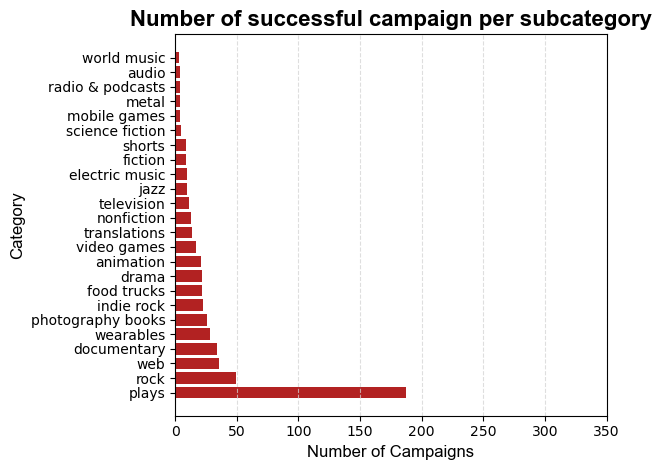

In [10]:
# Create a basic plot
plt.barh(df.subcategory, df.successful_campaigns, color="firebrick", align="center")

# Customizations

# Change colors
# Add in reference lines
# Add Labels/Title
plt.xlabel("Number of Campaigns", fontfamily="Arial", fontsize=12)
plt.ylabel("Category", fontfamily="Arial", fontsize=12)
plt.title("Number of successful campaign per subcategory", fontweight="bold", fontsize=16, fontfamily="Arial")

# Set X/Y Limits
plt.xlim(0, 350)

# Add in a background grid
plt.grid(axis="x", linestyle="--", color="lightgrey", alpha=0.75)

# Show/Save the Graph
plt.tight_layout()
#plt.savefig("part4_categories.png")
plt.show()